In [2]:
#Handle general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.interpolate import interp1d
import sys

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


structuring_code_path = "../structuring_code/"
sum_path = "../joule_declass_sum/"
raw_path = "../joule_declass_raw/"
joule_cell_id_path =  "../Joule_cell_id.csv"
sys.path.insert(0, structuring_code_path)




In [7]:
#Load functions from modules of interest
from Joule_sum_data_builder import load_sum_obj
from plotting_and_fitting_helpers import local_reg_adjust_window, get_smoothed_cap_eol_time

In [8]:
joule_cell_id_df = pd.read_csv(joule_cell_id_path)

cell_type_list=['Panasonic NCR18650GA', 'Panasonic NCR18650B', 'K2 Energy LFP18650P', 
                'K2 Energy LFP18650E', 'Ultralife UBP001', 'Ultralife 502030', 
                'Sony-Murata US18650VTC6', 'Tenergy 302030']

joule_cell_id_df_to_use = joule_cell_id_df[joule_cell_id_df["Cell_type"].isin(cell_type_list)]

In [43]:
#Set plotting parameters
font_size_set = 8

plt.rc('font', size=font_size_set)          # controls default text sizes
plt.rc('axes', titlesize=font_size_set)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_set)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size_set)    # legend fontsize
plt.rc('figure', titlesize=font_size_set)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rc("lines", lw=1)

#Plotting color dictionary of form color_temp_soc_dict[temperature][SOC]
color_temp_soc_dict = {24: {50: "lightsteelblue", 100: "royalblue"}, 45: {50: "gold", 100: "darkgoldenrod"}, 
                    60: {50:"#fcca8d", 100: "darkorange"}, 85: {50: "lightcoral", 100: "firebrick"}}


alpha = 0.7

100%|██████████| 232/232 [00:01<00:00, 136.45it/s]


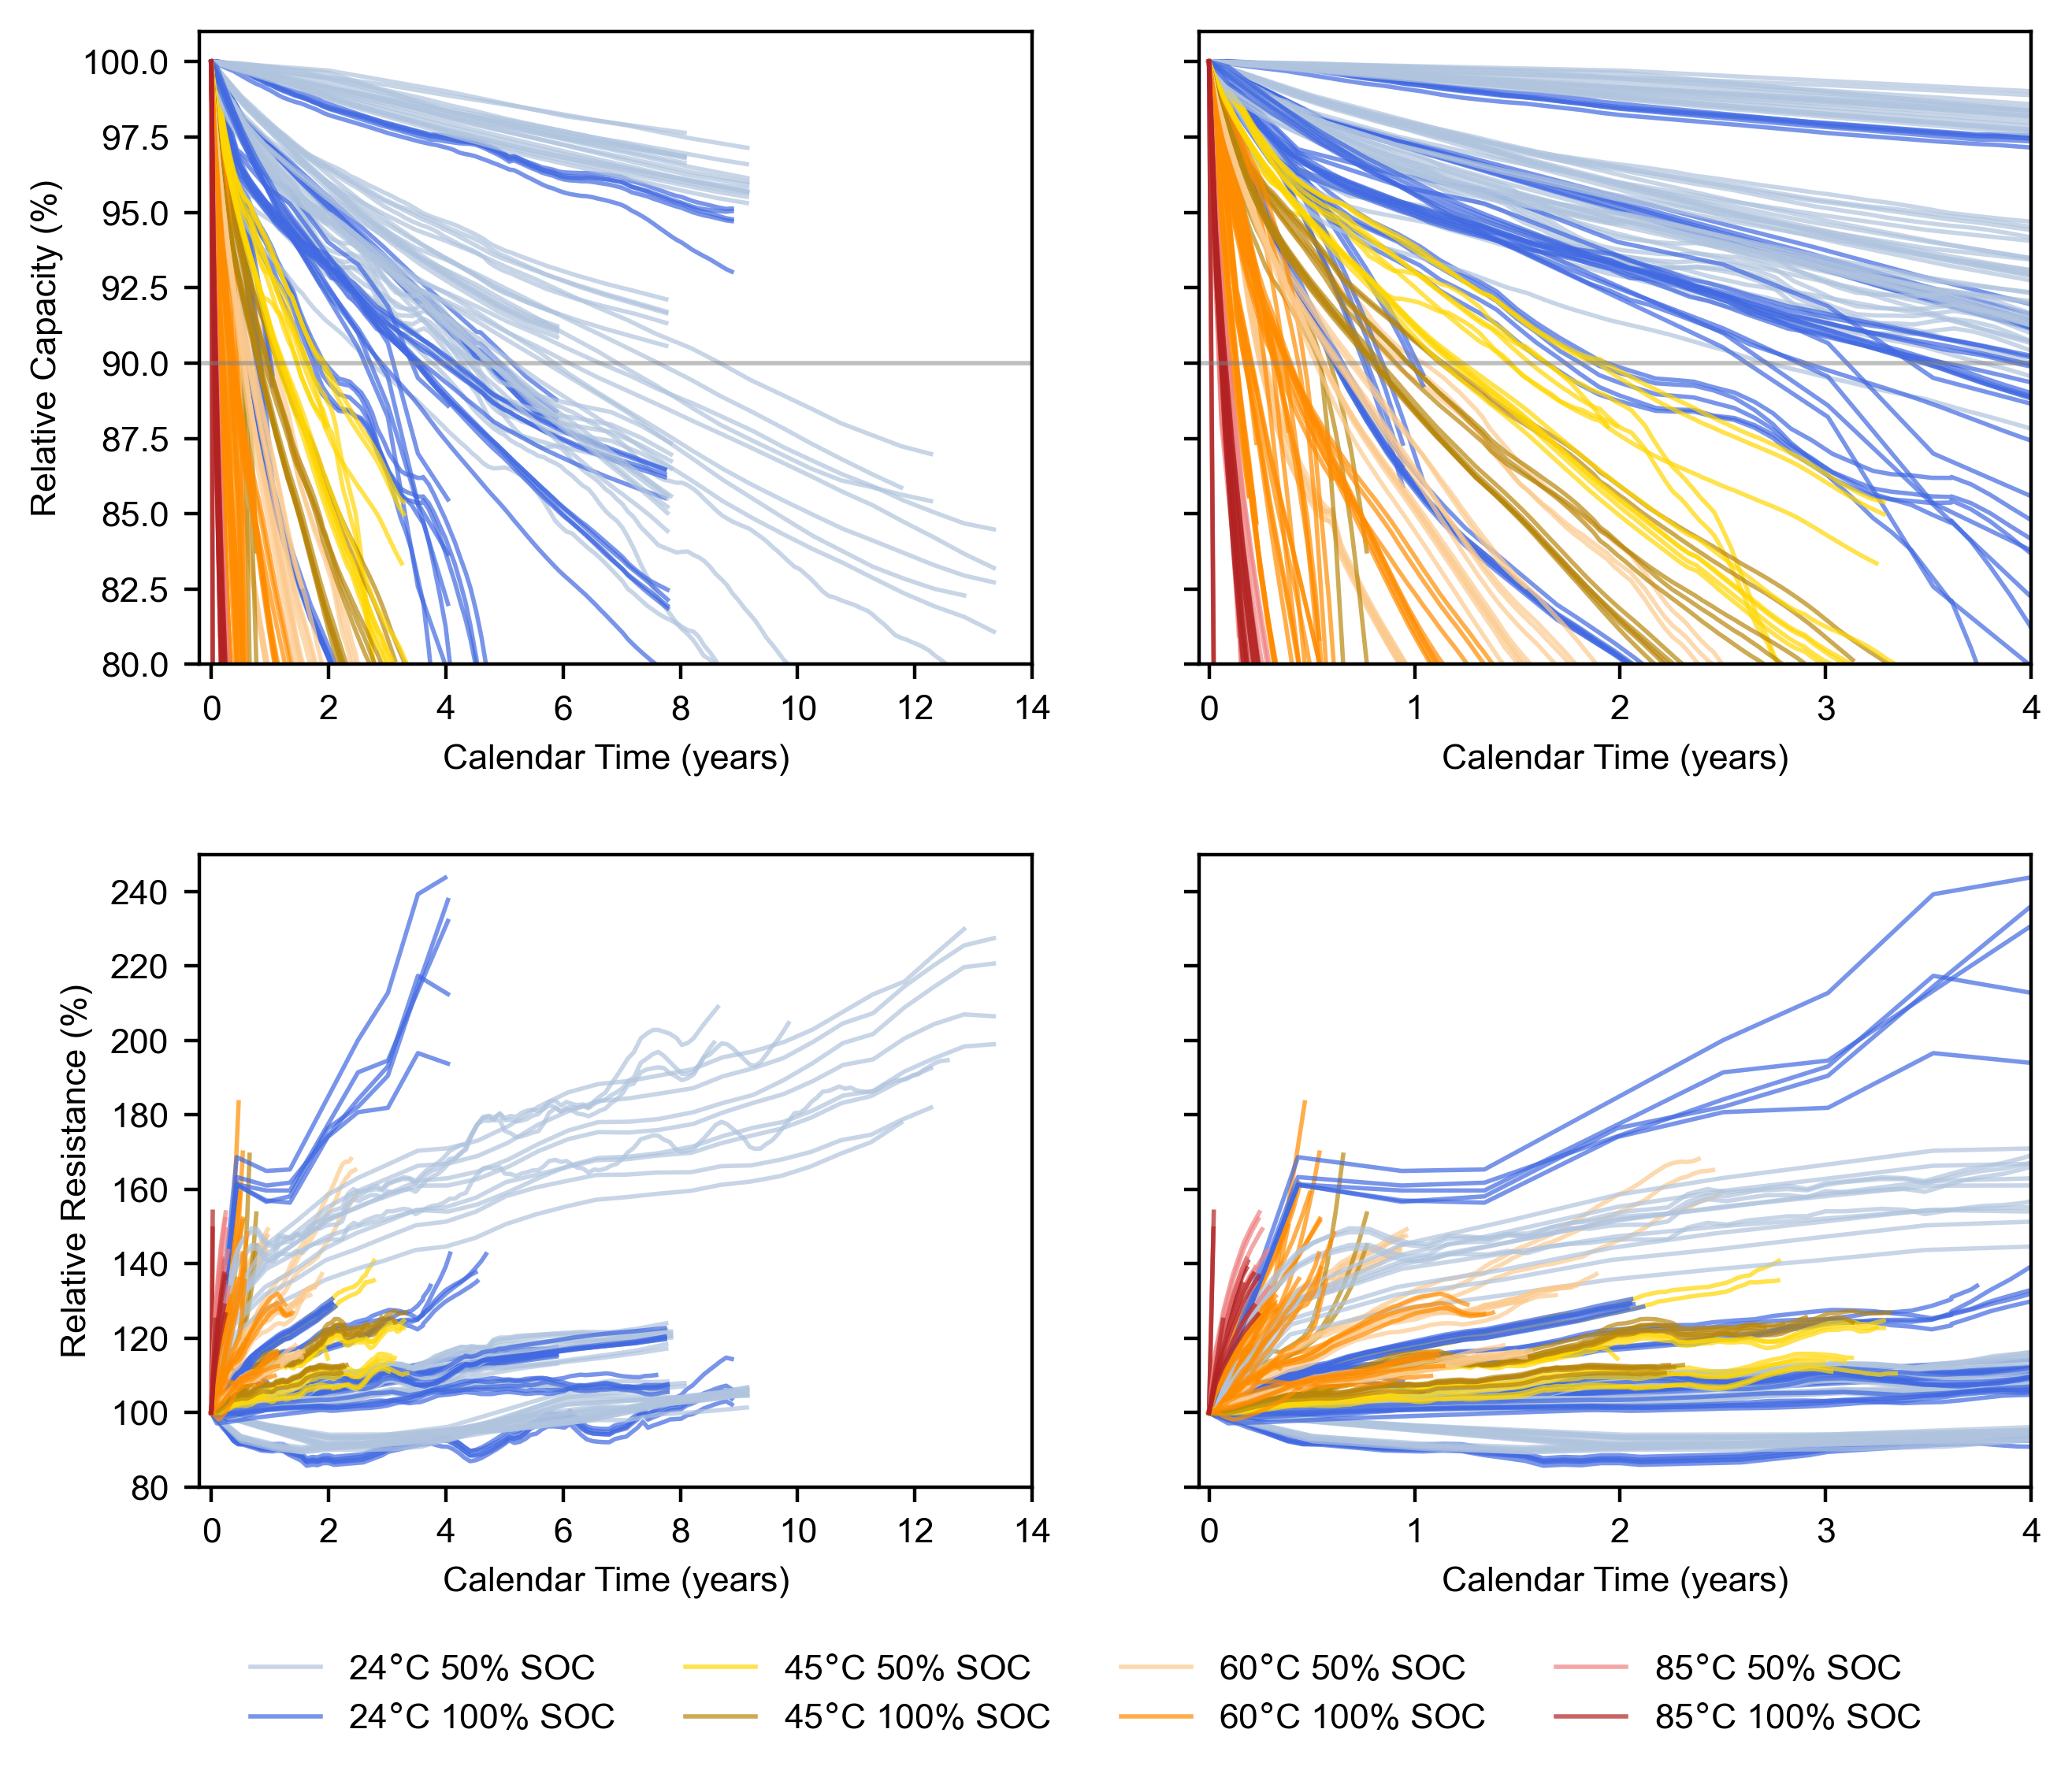

In [44]:

cap_metric = "RPT0.2C_2_D_capacity"
res_metric = "Res_SS_2_D"
#7.5" is actually 6.5" because of bbox_inches tight removing 1" margins
fig,axs = plt.subplots(2,2,figsize=(7.5,6), dpi=400, sharey="row")

filtered = True
#EOL capacity to plot until
eol_cap_frac=0.8
eol_cond_perc = eol_cap_frac*100

color_list = ["royalblue", "gold", "darkorange", "firebrick"]

for idx in tqdm(range(len(joule_cell_id_df_to_use[:]))):
    cell_id = joule_cell_id_df_to_use.iloc[idx]["Cell_id"]
    sum_name = "{}_sum.json".format(cell_id)
    sum_obj=load_sum_obj(file_path=sum_path+sum_name)
    df = sum_obj.summary_data
    metric_points = df[cap_metric]
    time_points = np.array(df["Calendar_DateTime(days)"])/365 #convert to years

    if filtered:
        if(len(time_points))<4:
            continue
        rel_metric_points = (metric_points/metric_points[0])*100
        rel_smoothed_metric_points = local_reg_adjust_window(time_points, rel_metric_points, deg=2)
        time_to_plot = time_points
        metric_to_plot = rel_smoothed_metric_points
    else:
        time_to_plot = time_points
        metric_to_plot = (metric_points/metric_points[0])*100

    #get color
    temp = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==str(cell_id)]["Temperature"].iloc[0]
    soc = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==str(cell_id)]["SOC"].iloc[0]
    color = color_temp_soc_dict[temp][soc]

    axs[0,0].plot(time_to_plot, metric_to_plot, color=color, alpha = alpha)
    axs[0,1].plot(time_to_plot, metric_to_plot, color=color, alpha = alpha)


#### Plotting for Resistance now

for idx in tqdm(range(len(joule_cell_id_df_to_use[:]))):
    cell_id = joule_cell_id_df_to_use.iloc[idx]["Cell_id"]
    sum_name = "{}_sum.json".format(cell_id)
    
    try:
        sum_obj=load_sum_obj(file_path=sum_path+sum_name)
    except:
        continue

    df = sum_obj.summary_data
    res_points = np.array(df[res_metric])
    rel_res_points = (res_points/res_points[0])*100

    time_points = np.array(df["Calendar_DateTime(days)"])/365 #convert to years
    cap_points = df[cap_metric]

    #I should plot out the last point
    if filtered:
        if(len(time_points))<4:
            continue

        rel_smoothed_res_points = local_reg_adjust_window(time_points, rel_res_points, deg=2)

        #If the last datapoint is below the eol capacity we will interpolate
        if cap_points.iloc[-1]<cap_points.iloc[0]*eol_cap_frac:
            #Will throw an error if edge case of smoothed last datapoint above eol cap
            try:
                _, eol_time = get_smoothed_cap_eol_time(time_points, cap_points, eol_cond=eol_cond_perc)
                
                #get a function of the smoothed resistance vs time
                res_time_fun = interp1d(time_points, rel_smoothed_res_points)

                #Constrain metric_to_plot to be before the eol_time
                metric_to_plot = rel_smoothed_res_points[time_points<eol_time]
                time_to_plot = time_points[time_points<eol_time]
                #add in the eol_time point
                metric_to_plot = np.append(metric_to_plot, res_time_fun(eol_time))
                time_to_plot = np.append(time_to_plot, eol_time)
            except:
                time_to_plot = time_points
                metric_to_plot = rel_smoothed_res_points
        
        #If it has not reached eol just plot what is available
        else:
            time_to_plot = time_points
            metric_to_plot = rel_smoothed_res_points


    #If not filtering just use data as is no interpolation
    else:
        time_to_plot = time_points[cap_points>cap_points.iloc[0]*eol_cap_frac]
        metric_to_plot = rel_res_points
        metric_to_plot = metric_to_plot[cap_points>cap_points.iloc[0]*eol_cap_frac]

    #get color
    cell_id = sum_name.split("_")[0]
    temp = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==str(cell_id)]["Temperature"].iloc[0]
    soc = joule_cell_id_df_to_use[joule_cell_id_df_to_use["Cell_id"]==str(cell_id)]["SOC"].iloc[0]
    color = color_temp_soc_dict[temp][soc]

    axs[1,0].plot(time_to_plot, metric_to_plot, color=color, alpha = alpha)
    axs[1,1].plot(time_to_plot, metric_to_plot, color=color, alpha = alpha)



### Setting axis labels etc

axs[0,0].set_ylabel("Relative Capacity (%)")
axs[0,0].set_xlabel("Calendar Time (years)")
xmin1 = -0.2
xmax1 = 14
axs[0,0].set_ylim([80, 101])
axs[0,0].set_xlim([xmin1, xmax1])
axs[0,0].set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
axs[0,0].hlines(90, xmin=xmin1,xmax= xmax1, color="gray", alpha=0.5)


xmin2 = -0.05
xmax2 = 4
axs[0,1].set_xlabel("Calendar Time (years)")
axs[0,1].set_ylim([80, 101])
axs[0,1].set_xlim([xmin2, xmax2])
axs[0,1].hlines(90, xmin=xmin2,xmax=xmax2, color="gray", alpha=0.5)

axs[1,0].set_ylabel("Relative Resistance (%)")
axs[1,0].set_xlabel("Calendar Time (years)")
axs[1,0].set_ylim([80, 250])
axs[1,0].set_xlim([xmin1, xmax1])
axs[1,0].set_xticks([0, 2, 4, 6, 8, 10, 12, 14])

axs[1,1].set_xlabel("Calendar Time (years)")
axs[1,1].set_xlim([xmin2, xmax2])

plt.subplots_adjust(hspace=0.3)



### Add the legend
temp_list = [24, 45, 60, 85]
soc_list = [50, 100]

temp_soc_handles = []
for temp in temp_list:
    for soc in soc_list:
        temp_soc_handles.append(Line2D([0], [0], label=r'{}$\degree$C {}% SOC'.format(temp, soc), 
                        color=color_temp_soc_dict[temp][soc], alpha=alpha))

fig.legend(handles=temp_soc_handles, loc='center', bbox_to_anchor=(0.5, 0), ncol=4, frameon=False)

#fig.savefig("../figures/cap_resistance_summary_plot.svg", transparent=True, format="svg", bbox_inches="tight")

plt.show()




